## EDA (Condensed)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split 

df = pd.read_csv("completed_flat_price_2017_2023.csv")
df['date'] = pd.to_datetime(df['month'], format='%Y-%m')

# pre processing:
# removing outliers (3std away) for resale_price
def three_sd_range(series):
    mean = series.mean()
    sd = series.std()
    low = mean - 3*sd
    high = mean + 3*sd
    return (low, high)

lower, upper = three_sd_range(df["resale_price"])
df_cleaned  = df[ (df.resale_price >= lower) & (df.resale_price <= upper) ]

# converting remaining_lease to int format:
def convert_lease_to_int(lease_str):
    parts = lease_str.split()
    years = int(parts[0])
    return years

df_cleaned['remaining_lease_years'] = df['remaining_lease'].apply(convert_lease_to_int)

# encoding flat_type and storey_range to ordinal data:
labelencoder = LabelEncoder()
df_cleaned['flat_type_encoded'] = labelencoder.fit_transform(df_cleaned['flat_type'])
df_cleaned['storey_range_encoded'] = labelencoder.fit_transform(df_cleaned['storey_range'])


<ipython-input-1-592bc9ef9ee1>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['remaining_lease_years'] = df['remaining_lease'].apply(convert_lease_to_int)
<ipython-input-1-592bc9ef9ee1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['flat_type_encoded'] = labelencoder.fit_transform(df_cleaned['flat_type'])
<ipython-input-1-592bc9ef9ee1>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

#### Inflation using CPI

In [2]:
# Read the CSV file. The header is in the first row by default.
inflation_rate = pd.read_csv('annual_CPI.csv')

# Transpose the DataFrame so that years become the index
inflation_rate = inflation_rate.transpose().reset_index()
inflation_rate.columns = ['Year', 'CPI']  # Renaming the columns
inflation_rate.sort_index(ascending=False, inplace=True)

# Convert 'Year' to integer and 'CPI' to float
inflation_rate['Year'] = inflation_rate['Year'].astype(int)
inflation_rate['CPI'] = inflation_rate['CPI'].astype(float)

# Calculate the inflation rate
inflation_rate['Inflation Rate'] = inflation_rate['CPI'].diff() / inflation_rate['CPI'].shift(1) * 100

# Setting the inflation rate for the base year (the first year) to 0%
inflation_rate.iloc[0, inflation_rate.columns.get_loc('Inflation Rate')] = 0

# Display the DataFrame
print(inflation_rate)

   Year      CPI  Inflation Rate
6  2017   99.004        0.000000
5  2018   99.438        0.438366
4  2019  100.000        0.565176
3  2020   99.818       -0.182000
2  2021  102.119        2.305195
1  2022  108.370        6.121290
0  2023  113.595        4.821445


#### Calculating adjusted price with inflation

In [3]:
# Add a 'year' column to df2 by converting 'month' to datetime and extracting the year
df_cleaned['year'] = pd.to_datetime(df_cleaned['month']).dt.year

# Merge df2 with the inflation_rate DataFrame on the 'year' column
# Make sure the inflation_rate DataFrame has 'Year' and 'Inflation Rate' columns
df_cleaned = df_cleaned.merge(inflation_rate, left_on='year', right_on='Year', how='left')

# Calculate the adjusted_price
df_cleaned['adjusted_price'] = round(df_cleaned['resale_price'] * (1 + df_cleaned['Inflation Rate'] / 100),2)

# Since we only need the adjusted_price, drop the extra columns
df_cleaned.drop(columns=['Year', 'Inflation Rate', 'year'], inplace=True)

# extracting features:
df2= df_cleaned[['month','town', 
                 'flat_type', 'flat_type_encoded',
                 'storey_range', 'storey_range_encoded',
                 'floor_area_sqm', 'remaining_lease_years', 'full_address', 'adjusted_price']]

<ipython-input-3-b94382874872>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['year'] = pd.to_datetime(df_cleaned['month']).dt.year


#### Normalisation of continuous variables 
Floor area, remaining lease years, resale price

In [4]:
# Applying one hot encoding to town:
from sklearn.preprocessing import LabelBinarizer
labelbinarizer = LabelBinarizer()
x = labelbinarizer.fit_transform(df2["town"])
encoded_df = pd.DataFrame(x, columns=labelbinarizer.classes_)
encoded_df.head()

# Normalizing numerical variables:
from sklearn.preprocessing import StandardScaler
columns = [ 'floor_area_sqm', 'remaining_lease_years', 'adjusted_price']
df2_normalized = StandardScaler().fit_transform(df2[columns])
df2_normalized= pd.DataFrame(df2_normalized, columns = columns)

df2 = df2.reset_index(drop=True)
df2_normalized = df2_normalized.reset_index(drop=True)

df2_normalized[['flat_type_encoded', 'storey_range_encoded']] = df2[['flat_type_encoded', 'storey_range_encoded']]
df2_normalized['year'] = df2['month'].str.slice(0,4)
df2_normalized = pd.concat([df2_normalized, encoded_df], axis=1)

# Change data type of year to int
df2_normalized['year'] = df2_normalized['year'].astype(int)

df2_normalized

,floor_area_sqm,remaining_lease_years,adjusted_price,flat_type_encoded,storey_range_encoded,year,ANG MO KIO,BEDOK,BISHAN,BUKIT BATOK,...,PASIR RIS,PUNGGOL,QUEENSTOWN,SEMBAWANG,SENGKANG,SERANGOON,TAMPINES,TOA PAYOH,WOODLANDS,YISHUN
0,-2.225324,-0.969351,-1.537938,1,3,2017,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1.266810,-1.042624,-1.427477,2,0,2017,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1.266810,-0.896079,-1.353836,2,0,2017,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.225135,-0.896079,-1.335426,2,1,2017,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1.266810,-0.896079,-1.335426,2,0,2017,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145605,0.983615,-0.822806,1.155218,4,2,2023,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
145606,1.233662,-0.749534,1.541176,4,0,2023,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
145607,1.025289,-0.749534,1.541176,4,3,2023,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
145608,2.025478,-0.749534,2.428879,5,3,2023,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


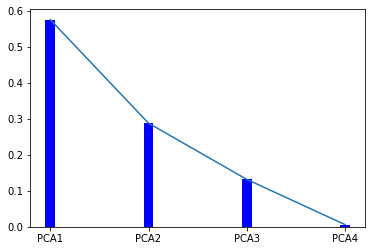

In [5]:
# PCA
from sklearn.decomposition import PCA

# pca = PCA(n_components=3)
pca = PCA(n_components=4)

# x_pca = pca.fit_transform(df2_normalized[['floor_area_sqm', 'remaining_lease_years', 'resale_price']])
x_pca = pca.fit_transform(df2_normalized[['floor_area_sqm', 'remaining_lease_years', 'flat_type_encoded', 'storey_range_encoded']])

x_pca = pd.DataFrame(x_pca)
df4_names = []
y= pca.explained_variance_ratio_

for i in range(len(y)):
    df4_names.append('PCA'+str(i+1))

default_x_ticks = range(len(df4_names))

plt.plot(default_x_ticks, y)
plt.bar(default_x_ticks, y,width=0.1,color= 'blue')
plt.xticks(default_x_ticks, df4_names)
plt.show()

In [6]:
# Splitting into 3 df: pre-covid, post-covid, and full dataset
full_dataset = df2_normalized
precovid_dataset = df2_normalized[(df2_normalized['year'] >= 2017) & (df2_normalized['year'] <= 2019)] # Data from 2017 ~ 2019
postcovid_dataset = df2_normalized[(df2_normalized['year'] >= 2020) ] # Data from 2020 ~ 2023

# Extracting essential columns for model training
full_dataset = full_dataset[['floor_area_sqm', 'remaining_lease_years', 'flat_type_encoded', 'storey_range_encoded', 'adjusted_price']]
precovid_dataset = precovid_dataset[['floor_area_sqm', 'remaining_lease_years', 'flat_type_encoded', 'storey_range_encoded', 'adjusted_price']]
postcovid_dataset = postcovid_dataset[['floor_area_sqm', 'remaining_lease_years', 'flat_type_encoded', 'storey_range_encoded', 'adjusted_price']]

In [7]:
# splitting into train-test split for all 3 data sets
# use randome state=42

# For full_dataset:
X1=full_dataset.drop(columns='adjusted_price')
y1= full_dataset['adjusted_price']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

# For precovid_dataset:
X2=precovid_dataset.drop(columns='adjusted_price')
y2= precovid_dataset['adjusted_price']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# For postcovid_dataset:
X3=postcovid_dataset.drop(columns='adjusted_price')
y3= postcovid_dataset['adjusted_price']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

## CNN (Convolutional Neural Network)

In [8]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from joblib import dump, load
import os

# Define the model
def buildModel(input_dim, units1=256, units2=128, units3=64, dropout1=0.2, dropout2=0.2, dropout3=0.2):
    model = Sequential()
    model.add(Dense(units=units1, input_dim=input_dim, activation='relu'))
    model.add(Dropout(dropout1))
    model.add(Dense(units=units2, activation='relu'))
    model.add(Dropout(dropout2))
    model.add(Dense(units=units3, activation='relu'))
    model.add(Dropout(dropout3))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

# Define grid search parameters for hyperparameter tuning (modify as needed)
param_grid = {
    'epochs': [50], # [50, 100, 150],
    'batch_size': [128], # [32, 64, 128],
    'units1': [256], # [128, 256, 512],
    'units2': [128], # [64, 128, 256],
    'units3': [64], # [32, 64, 128],
    'dropout1': [0.2], # [0.1, 0.2, 0.3],
    'dropout2': [0.2], # [0.1, 0.2, 0.3],
    'dropout3': [0.2] # [0.1, 0.2, 0.3]
}

model_example = buildModel(X_train1.shape[1])
model_example.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

#### Full Dataset

In [9]:
if (not os.path.exists('gridsearch/CNN_fulldata.joblib')):

    # Create a KerasRegressor
    regressor_fulldata = KerasRegressor(model=buildModel, input_dim=X_train1.shape[1], verbose=0, epochs=100, batch_size=32, units1=256, units2=128, units3=64, dropout1=0.2, dropout2=0.2, dropout3=0.2)

    # Create a GridSearchCV and fit the model
    grid_fulldata = GridSearchCV(estimator=regressor_fulldata, param_grid=param_grid, cv=3, verbose=3)
    grid_result_fulldata = grid_fulldata.fit(X_train1, y_train1)

    # Summarize results
    print(f"Best: {grid_result_fulldata.best_score_} using {grid_result_fulldata.best_params_}")

    # Save grid_result to a file
    dump(grid_result_fulldata, 'gridsearch/CNN_fulldata.joblib')

else:
    # Load grid_result from a file
    grid_result_fulldata = load('gridsearch/CNN_fulldata.joblib')

    # Summarize results
    print(f"Best: {grid_result_fulldata.best_score_} using {grid_result_fulldata.best_params_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END batch_size=128, dropout1=0.2, dropout2=0.2, dropout3=0.2, epochs=50, units1=256, units2=128, units3=64;, score=0.621 total time= 2.2min
[CV 2/3] END batch_size=128, dropout1=0.2, dropout2=0.2, dropout3=0.2, epochs=50, units1=256, units2=128, units3=64;, score=0.620 total time= 2.0min
[CV 3/3] END batch_size=128, dropout1=0.2, dropout2=0.2, dropout3=0.2, epochs=50, units1=256, units2=128, units3=64;, score=0.624 total time= 2.1min
Best: 0.6215555827320893 using {'batch_size': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.2, 'epochs': 50, 'units1': 256, 'units2': 128, 'units3': 64}
INFO:tensorflow:Assets written to: C:\Users\ryanc\AppData\Local\Temp\tmpcubtrl2s\assets


INFO:tensorflow:Assets written to: C:\Users\ryanc\AppData\Local\Temp\tmpcubtrl2s\assets


In [10]:
# Load and evaluate the model with the test data using the best hyperparameters
grid_result_fulldata = load('gridsearch/CNN_fulldata.joblib')
test_score = grid_result_fulldata.score(X_test1, y_test1)
print(f"Test MAE: {test_score}")

Test MAE: 0.6203775942598053


#### Pre-COVID Dataset

In [11]:
if (not os.path.exists('gridsearch/CNN_precovid.joblib')):

    # Create a KerasRegressor
    regressor_precovid = KerasRegressor(model=buildModel, input_dim=X_train2.shape[1], verbose=0, epochs=100, batch_size=32, units1=256, units2=128, units3=64, dropout1=0.2, dropout2=0.2, dropout3=0.2)

    # Create a GridSearchCV and fit the model
    grid_precovid = GridSearchCV(estimator=regressor_precovid, param_grid=param_grid, cv=3, verbose=3)
    grid_result_precovid = grid_precovid.fit(X_train2, y_train2)

    # Summarize results
    print(f"Best: {grid_result_precovid.best_score_} using {grid_result_precovid.best_params_}")

    # Save best model
    dump(grid_result_precovid, 'gridsearch/CNN_precovid.joblib')

else:
    # Load grid_result from a file
    grid_result_precovid = load('gridsearch/CNN_precovid.joblib')

    # Summarize results
    print(f"Best: {grid_result_precovid.best_score_} using {grid_result_precovid.best_params_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END batch_size=128, dropout1=0.2, dropout2=0.2, dropout3=0.2, epochs=50, units1=256, units2=128, units3=64;, score=0.636 total time=  34.4s
[CV 2/3] END batch_size=128, dropout1=0.2, dropout2=0.2, dropout3=0.2, epochs=50, units1=256, units2=128, units3=64;, score=0.646 total time=  37.2s
[CV 3/3] END batch_size=128, dropout1=0.2, dropout2=0.2, dropout3=0.2, epochs=50, units1=256, units2=128, units3=64;, score=0.636 total time=  36.0s
Best: 0.6394627459363781 using {'batch_size': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.2, 'epochs': 50, 'units1': 256, 'units2': 128, 'units3': 64}
INFO:tensorflow:Assets written to: C:\Users\ryanc\AppData\Local\Temp\tmpefmielrd\assets


INFO:tensorflow:Assets written to: C:\Users\ryanc\AppData\Local\Temp\tmpefmielrd\assets


In [12]:
# Load and evaluate the model with the test data using the best hyperparameters
grid_result_precovid = load('gridsearch/CNN_precovid.joblib')
test_score = grid_result_precovid.score(X_test2, y_test2)
print(f"Test MAE: {test_score}")

Test MAE: 0.6336327409450735


#### Post-COVID Dataset

In [13]:
if (not os.path.exists('gridsearch/CNN_postcovid.joblib')):

    # Create a KerasRegressor
    regressor_postcovid = KerasRegressor(model=buildModel, input_dim=X_train3.shape[1], verbose=0, epochs=100, batch_size=32, units1=256, units2=128, units3=64, dropout1=0.2, dropout2=0.2, dropout3=0.2)

    # Create a GridSearchCV and fit the model
    grid_postcovid = GridSearchCV(estimator=regressor_postcovid, param_grid=param_grid, cv=3, verbose=3)
    grid_result_postcovid = grid_postcovid.fit(X_train3, y_train3)

    # Summarize results
    print(f"Best: {grid_result_postcovid.best_score_} using {grid_result_postcovid.best_params_}")

    # Save best model
    dump(grid_result_postcovid, 'gridsearch/CNN_postcovid.joblib')

else:
    # Load grid_result from a file
    grid_result_postcovid = load('gridsearch/CNN_postcovid.joblib')

    # Summarize results
    print(f"Best: {grid_result_postcovid.best_score_} using {grid_result_postcovid.best_params_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END batch_size=128, dropout1=0.2, dropout2=0.2, dropout3=0.2, epochs=50, units1=256, units2=128, units3=64;, score=0.638 total time= 1.4min
[CV 2/3] END batch_size=128, dropout1=0.2, dropout2=0.2, dropout3=0.2, epochs=50, units1=256, units2=128, units3=64;, score=0.633 total time= 1.3min
[CV 3/3] END batch_size=128, dropout1=0.2, dropout2=0.2, dropout3=0.2, epochs=50, units1=256, units2=128, units3=64;, score=0.620 total time=  54.5s
Best: 0.6302954910119157 using {'batch_size': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.2, 'epochs': 50, 'units1': 256, 'units2': 128, 'units3': 64}
INFO:tensorflow:Assets written to: C:\Users\ryanc\AppData\Local\Temp\tmpguurchd6\assets


INFO:tensorflow:Assets written to: C:\Users\ryanc\AppData\Local\Temp\tmpguurchd6\assets


In [14]:
# Load and evaluate the model with the test data using the best hyperparameters
grid_result_postcovid = load('gridsearch/CNN_postcovid.joblib')
test_score = grid_result_postcovid.score(X_test3, y_test3)
print(f"Test MAE: {test_score}")

Test MAE: 0.6432590027280882


### Comparing Models

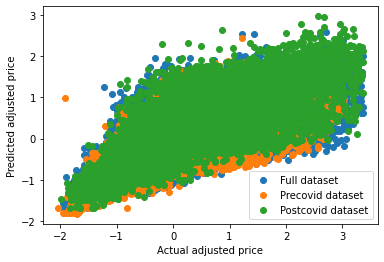

(Full) Correlation coefficient: 0.7883531185649709
(Precovid) Correlation coefficient: 0.8020261540748805
(Postcovid) Correlation coefficient: 0.8036397185524564
--------------------------------------------------
(Full) R2 score: 0.6203775942598053
(Precovid) R2 score: 0.6336327409450735
(Postcovid) R2 score: 0.6432590027280882


In [18]:
# Predict the adjusted price
y_pred_fulldata = grid_result_fulldata.predict(X_test1)
y_pred_precovid = grid_result_precovid.predict(X_test2)
y_pred_postcovid = grid_result_postcovid.predict(X_test3)

# Plot the predicted adjusted price against the actual adjusted price
plt.scatter(y_test1, y_pred_fulldata, label='Full dataset')
plt.scatter(y_test2, y_pred_precovid, label='Precovid dataset')
plt.scatter(y_test3, y_pred_postcovid, label='Postcovid dataset')
plt.xlabel('Actual adjusted price')
plt.ylabel('Predicted adjusted price')
plt.legend()
plt.show()

# Calculate the correlation coefficient
correlation_fulldata = np.corrcoef(y_test1, y_pred_fulldata.flatten())[0, 1]
correlation_precovid = np.corrcoef(y_test2, y_pred_precovid.flatten())[0, 1]
correlation_postcovid = np.corrcoef(y_test3, y_pred_postcovid.flatten())[0, 1]

print('(Full) Correlation coefficient:', correlation_fulldata)
print('(Precovid) Correlation coefficient:', correlation_precovid)
print('(Postcovid) Correlation coefficient:', correlation_postcovid)

# Calculate r2 score
from sklearn.metrics import r2_score
r2_fulldata = r2_score(y_test1, y_pred_fulldata)
r2_precovid = r2_score(y_test2, y_pred_precovid)
r2_postcovid = r2_score(y_test3, y_pred_postcovid)
print('-'*50)
print('(Full) R2 score:', r2_fulldata)
print('(Precovid) R2 score:', r2_precovid)
print('(Postcovid) R2 score:', r2_postcovid)